### This is a small example of what can be implemented in current version

In [1]:
from synaptics import * # Synaptics includes import of layers and numpy
from visual_env import *
from stats import *

#### Let's build our model
In current version, the model as a single object is not implemented, so we basically create layers of neurons and synapses.
<br/>We will use a frame 5 by 5 as visual environment, and the object is a oblique line that moves in two directions (left-right, up-down, doesn't really matter because of it's symmetry)

In [2]:
frame_size = 5,5 # define the frame size

input_size = frame_size[0] * frame_size[1] # area of the frame is equal to amount of input neurons
output_size = 1 # the model will have only one neuron in this case. It should generate spikes once familiar pattern is spotted
resolution = .1 # this parameter describes how often neural dynamics data is updated
preset = 'RS' # the type of neuron's dynamics from Izhikevich paper - https://ieeexplore.ieee.org/document/1257420
tau = 30 # characteristic time of STDP. In current version, this variable is integrated in neuron's model. Later it probably will be moved to Synapse

# Creating layers themselves, we will have two of them:
input_layer = IzhikevichLayer(size=input_size, resolution=resolution, tau=tau,
                              preset=preset, noize=1)
output_layer = IzhikevichLayer(size=output_size, resolution=resolution, tau=tau,
                               preset=preset, noize=1)

# Creating connections between layers (e.g. synapses):
synapse = Synapse(input_layer, output_layer)

# We will set all weights to 1. Empirically, that is the best way to train such model:
synapse.weights *= 0
synapse.weights += 1

print(synapse.weights.T)

g = 47 # this parameter scales the impact of presynaptic action potentials to postsynaptic activation
input_layer.transmitter_impact = g
print(synapse.weights.reshape(5,5))

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1.]]
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


Our moving pattern will be an oblique line

In [3]:
vis = motion_pic(size=frame_size) # Creating the visual field
pattern = np.eye(5)* 20
vis.add_object(pattern) # Adding the patern
vis.set_position_lazy(x='centered', y='centered')
print(f'This is how our pattern looks like: \n', vis.show_current_state())

This is how our pattern looks like: 
 [[20.  0.  0.  0.  0.]
 [ 0. 20.  0.  0.  0.]
 [ 0.  0. 20.  0.  0.]
 [ 0.  0.  0. 20.  0.]
 [ 0.  0.  0.  0. 20.]]


In [4]:
vis.set_position_lazy(x='left', y='centered') # let's say, we aregoing to move our pattern from left to the right

In [5]:
# these objects will help us to estimate firing rates:
rates0 = rate_capture(input_layer)
rates1 = rate_capture(output_layer)

In [6]:
# Notice that hyperparameters are not at optimal value. Tuning them is in my to-do list
# As well as annotating the rest of the code
def train_model(t, vis, rates1, resolution=.1, delay=4,
                 gather_data = True, train=False, lr = .001, alpha = 5):
    time = int(t / resolution)
    pattern_delay = int(delay/ resolution)
    directions = 'right',
    positions = 'left',
    v1_right = []
    v1_left = []
    v0_right = []
    v0_left = []
    weights_hist = []
    direction = directions[0]
    position = positions[0]

    vis.set_position_lazy(x='left', y='centered')
    print(f'Moving pattern to the {direction}')
    for j in range(time):
        synapse.forward()
        picture = vis.tick(delay=pattern_delay, move_direction=direction, noise_density=.1, noise_acceleration=5, rest=int(120/resolution))
        input_layer.apply_current(picture.flatten())
        output_layer.forward()
        rates0.accumulate_spikes()
        rates1.accumulate_spikes()
        if train:
            synapse.STDP(learning_rate=lr, assymetry=alpha)
        if gather_data:
            if direction == 'right':
                v0_right.append(input_layer.v.tolist())
                v1_right.append(output_layer.v.item())
            if direction == 'left':
                v0_left.append(input_layer.v.tolist())
                v1_left.append(output_layer.v.item())
            weights_hist.append(synapse.weights.tolist())
            
    input_layer.instant_rest()
    output_layer.instant_rest()
    r1 = rates1.compute_spike_rates(time=t, interval=1000)
    rates0.reset()
    rates1.reset()
    print(f'{position}-{direction} direction output rates', r1)
    print('Completed!')
    return v0_right, v0_left, v1_right, v1_left, weights_hist

In [7]:
v0_right, v0_left, v1_right, v1_left, weights_hist = train_model(t=30000, vis=vis, rates1=rates1, train=True)
weights_hist = np.array(weights_hist)
v1_right = np.array(v1_right)
v1_left = np.array(v1_left)

Moving pattern to the right
left-right direction output rates [6.76666667]
Completed!


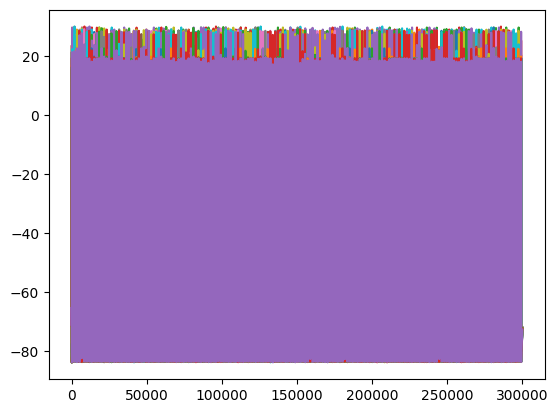

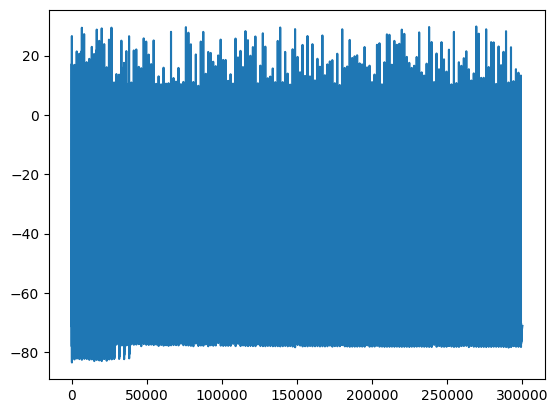

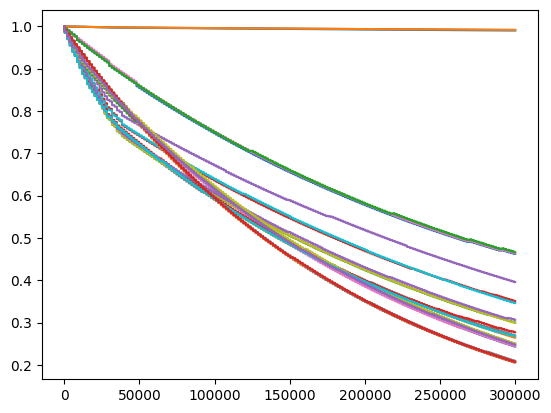

In [8]:
import matplotlib.pyplot as plt
plt.plot(v0_right)
plt.show()
plt.plot(v1_right)
plt.show()
for i in range(input_size):
    plt.plot(weights_hist[:,i])
plt.show()

[[0.2434 0.2643 0.2999 0.3505 0.3957]
 [0.2056 0.2439 0.2694 0.2991 0.346 ]
 [0.4624 0.2068 0.2498 0.277  0.3064]
 [0.9918 0.4639 0.2093 0.2501 0.2679]
 [0.9904 0.9918 0.4664 0.2073 0.2475]]


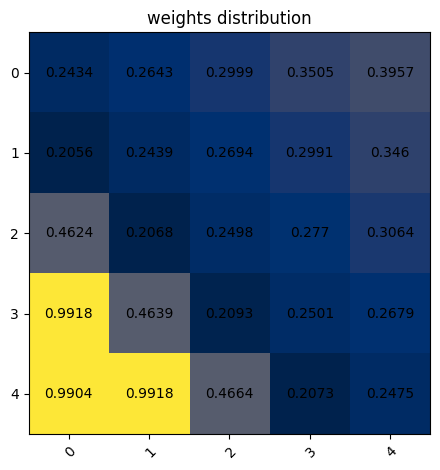

In [9]:
final_weights = synapse.weights.reshape(5,5).round(4)
print(final_weights)
fig, ax = plt.subplots()
im = ax.imshow(final_weights, cmap='cividis')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(5))
ax.set_yticks(np.arange(5))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(5):
    for j in range(5):
        text = ax.text(j, i, final_weights[i, j],
                       ha="center", va="center", color="black")

ax.set_title("weights distribution")
fig.tight_layout()
plt.show()

In [10]:
def test(t, vis, rates1, num_attempts=15, resolution=.1, delay=4):
    time = int(t / resolution)
    pattern_delay = int(delay/ resolution)
    directions = 'right', 'left'
    positions = 'left', 'right'
    r_right = []
    r_left = []

    for d in range(len(directions)):
        direction = directions[d]
        position = positions[d]
        for i in range(num_attempts):
            vis.set_position_lazy(x=position, y='centered')
            print(f'Moving pattern to the {direction}: attempt {i}')
            for j in range(time):
                synapse.forward()
                picture = vis.tick(delay=pattern_delay, move_direction=direction, noise_density=.1, noise_acceleration=5, rest=int(120/resolution))
                input_layer.apply_current(picture.flatten())
                output_layer.forward()
                rates0.accumulate_spikes()
                rates1.accumulate_spikes()
            input_layer.instant_rest()
            output_layer.instant_rest()
            r1 = rates1.compute_spike_rates(time=t, interval=1000)
            rates0.reset()
            rates1.reset()
            if direction == 'right':
                r_right.append(r1.item())
            else:
                r_left.append(r1.item())
    print('Completed!')
    return r_right, r_left

In [11]:
input_layer.transmitter_impact = 37
r_right, r_left = test(t=10000, vis=vis, rates1=rates1, num_attempts=5)

Moving pattern to the right: attempt 0
Moving pattern to the right: attempt 1
Moving pattern to the right: attempt 2
Moving pattern to the right: attempt 3
Moving pattern to the right: attempt 4
Moving pattern to the left: attempt 0
Moving pattern to the left: attempt 1
Moving pattern to the left: attempt 2
Moving pattern to the left: attempt 3
Moving pattern to the left: attempt 4
Completed!


In [12]:
print(r_right)
print(r_left)

[2.8, 2.6, 3.0, 2.6, 2.3]
[0.1, 0.0, 0.0, 0.0, 0.0]
